# Exercise 1: Neural Modelling and Analysis

Extension of https://oist.github.io/BrainComputation/Neurons.html

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

### 1. F-I curve for the H-H model

In [ ]:
def alpha_m(v):
    # sodium activation gate opening rate
    return 0.1*(v+40)/(1-np.exp(-(v+40)/10))
def beta_m(v):
    # sodium activation gate closing rate
    return 4*np.exp(-(v+65)/18)
def alpha_h(v):
    # sodium inactivation gate opening rate
    return 0.07*np.exp(-(v+65)/20)
def beta_h(v):
    # sodium inactivation gate closing rate
    return 1/(1+np.exp(-(v+35)/10))
def alpha_n(v):
    # potassium activation gate opening rate
    return 0.01*(v+55)/(1-np.exp(-(v+55)/10))
def beta_n(v):
    # potassium activation gate closing rate
    return 0.125*np.exp(-(v+65)/80)

# H-H: Hodgkin-Huxley (1952) model
C = 1.     # membrane capacitance (uF/cm^2)
# maximum conductances (uS/cm^2)
gna = 120. # sodium
gk = 36.   # potassium
gl = 0.3   # leak
# reversal potentials (mV)
Ena = 50.  # sodium
Ek = -77.  # potassium
El = -54.4 # leak
def hh(y, t, stim=0.):    
    # state variables: potential and activation/inactivation
    v, m, h, n = y
    # membrane potential
    if callable(stim):
        I = stim(t)  # time-dependent
    else:
        I = stim  # constant
    dv = (gna*m**3*h*(Ena-v) + gk*n**4*(Ek-v) + gl*(El-v) + I)/C
    # sodium current activation
    dm = alpha_m(v)*(1-m) - beta_m(v)*m
    # sodium current inactivation
    dh = alpha_h(v)*(1-h) - beta_h(v)*h
    # potassium current activation
    dn = alpha_n(v)*(1-n) - beta_n(v)*n
    return [ dv, dm, dh, dn]

# integrate ode and log steady state firing activity
def ss_spikes(y0, tt, t_transient=200, stim=0.):
    # steady state firing activity
    y = odeint(hh, y0, tt, args=(stim,))
    v = y[:, 0]
    # find spikes: passes through 0 from negative to positive
    spk_idx = np.where((v[:-1] < 0) & (v[1:] >= 0))[0] + 1 # sample post 0mV crossing
    spks = tt[spk_idx]
    return spks[spks > t_transient]  # discard transient spikes

Text(0, 0.5, 'I')

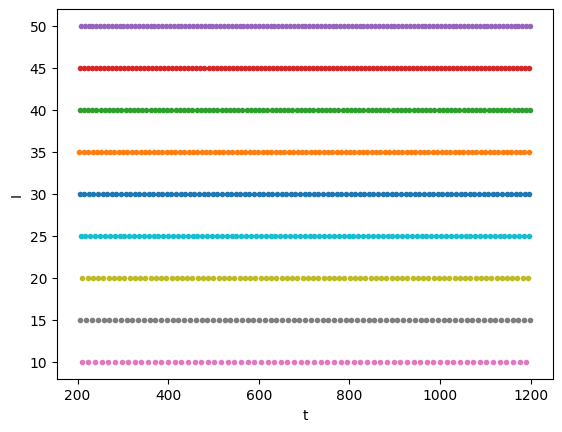

In [12]:
y0 = [-70, 0.1, 0.6, 0.4]    # initial state: V, m, h, n
tt = np.arange(0, 1200, 0.1) # integration time
Is = np.arange(-20, 51, 5)
Fs = []
for c, Ic in enumerate(Is):
    tf = ss_spikes(y0, tt, stim=Ic)
    plt.plot(tf, tf*0+Ic, '.')
    Fs.append(len(tf))
plt.xlabel("t")
plt.ylabel("I")

Text(0, 0.5, 'F (Hz)')

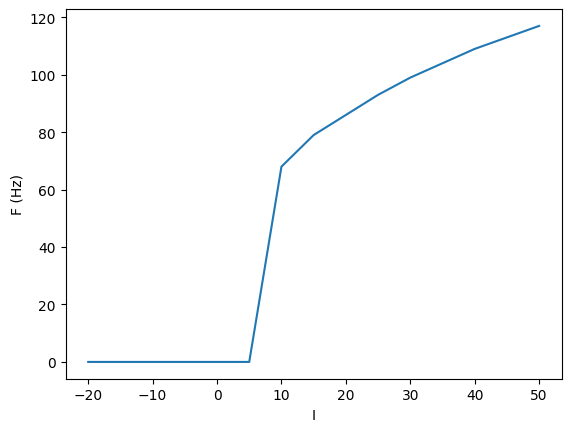

In [13]:
plt.plot(Is, Fs)
plt.xlabel("I")
plt.ylabel("F (Hz)")

Text(0, 0.5, 'F (Hz)')

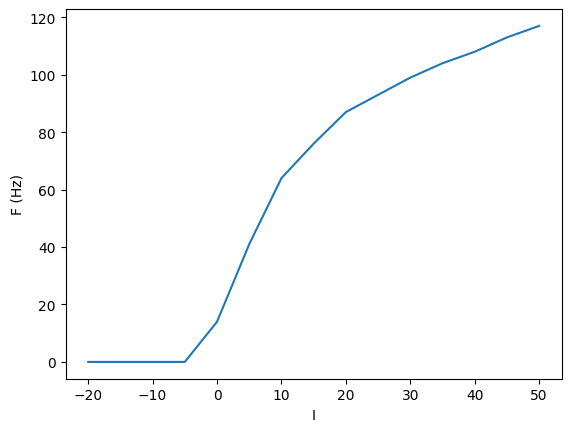

In [18]:
y0 = [-70, 0.1, 0.6, 0.4]    # initial state: V, m, h, n
tt = np.arange(0, 1200, 0.1) # integration time
In = 2  # noise size
noise = np.random.normal(0, 1, 1201)  # normal gaussian noise every 1ms
def Inoise(t):
    i = int(np.floor(t))
    return Ic + In*noise[i]
Fs = []
for c, Ic in enumerate(Is):
    tf = ss_spikes(y0, tt, stim=Inoise)
    Fs.append(len(tf))
plt.plot(Is, Fs)
plt.xlabel("I")
plt.ylabel("F (Hz)")

### 2. Network of IF neurons with simple pulse-connection instead of $\alpha$ function

In [ ]:
def alpha(t, tau_s=5): # integral = tau_s
    return t/tau_s*np.exp(-t/tau_s)
def delta(t): # integral = 1 (therefore expect less net spiking activity than with alpha synapses)
    return 1 if t == 0 else 0

Text(0, 0.5, 'V(t)')

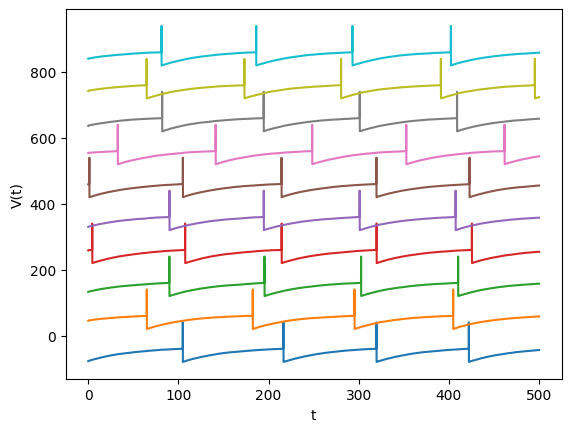

In [31]:
# setup iaf network with delta synapses (i.e. only instantaneous currents)
N = 10    # number of neurons
tau = 50  # membrane time constant
V0 = -45  # resting potential
Vth = -40 # threshold
Vs = 40   # spike height
Vr = -80  # reset
W = 40    # connection weight size; assume exponential distribution
w = np.random.exponential(W, N**2).reshape((N,N))
for i in range(N):
    w[i,i] = 0  # remove self-connection

# integrate ode
p_noise = 0.5
w_noise = 20
t_end = 500
dt = 0.1
v = np.random.uniform(Vr, Vth, size=N)
T = np.arange(0.0, t_end+dt, dt)
V = np.zeros((len(T), N))
last_spk = np.random.uniform(0, 1, size=N) < 0.5 # random initial spikes
for ti, t in enumerate(T):
    # record voltage before possible reset/spike
    V[ti] = v
    # subthreshold dynamics with random neurons affected by white noise at each step
    epsp = w.T.dot(last_spk.astype(float)) + (np.random.rand(N) < p_noise) * w_noise
    dv = dt * (-v + V0 + epsp) / tau
    v += dv
    # check for spikes
    last_spk = v >= Vth
    if last_spk.any():
        V[ti, last_spk] = Vs # for plotting
        v[last_spk] = Vr # reset actual voltage

# much more quiescent than the alpha synapse model
plt.plot(T, V + np.arange(N)*100)  # shift traces vertically
plt.xlabel("t")
plt.ylabel("V(t)")

### 3. RNN simulation with different connection weights

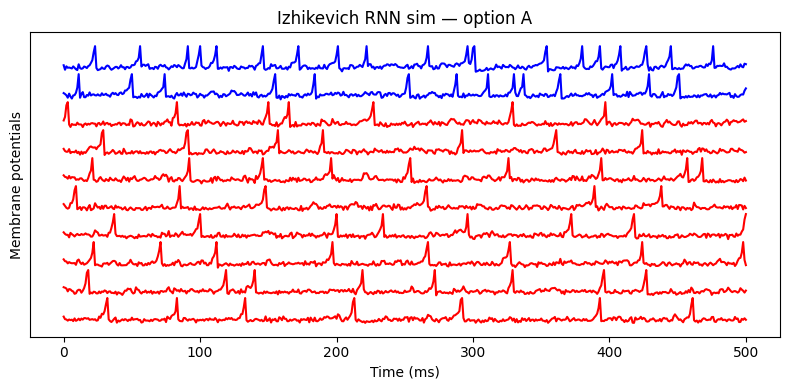

In [ ]:
# we use Izhikevich model neurons which are fully connected, recurrently
# those with positive outgoing weights: regular spiking (excitatory)
# those with negative outgoing weights: fast spiking (inhibitory)
# enforcing Dale's law: excitatory neurons only make excitatory connections and vice-versa
# we consider the following weight options:
# A: exponential distr for E and I; B: uniform [-5,5] distr for E and I; C: exponential distr E<->E
# -------------------------

# simulation and net size params
N = 10
dt, t_end = 1.0, 500.0
T = np.arange(0.0, t_end + dt, dt)

# dale's law
weight_option = 'A'
if weight_option == 'A':
    N_exc = math.floor(0.8*N)
    N_inh = N - N_exc
    W = np.zeros((N, N))
    exc = np.arange(N_exc)
    inh = np.arange(N_exc, N)
    W[exc, :] = np.random.exponential(scale=5.0, size=(N_exc, N))
    W[inh, :] = -np.random.exponential(scale=5.0, size=(N_inh, N))
elif weight_option == 'B':
    W = np.random.uniform(-5.0, 5.0, size=(N, N))
    pos = np.sum(W > 0, axis=1)
    neg = np.sum(W < 0, axis=1)
    exc = np.where(pos >= neg)[0] # majority positive weights
    inh = np.where(neg > pos)[0]  # majority negative weights
    W[exc, :] =  np.abs(W[exc, :])
    W[inh, :] = -np.abs(W[inh, :])
else:  # 'C'
    W = np.random.exponential(5.0, size=(N, N))
    exc = np.arange(N)
    inh = []
# remove self-connections
np.fill_diagonal(W, 0.0)

# Izhikevich params
a = np.empty(N); b = np.empty(N)
c = np.empty(N); d = np.empty(N)
# regular-spiking (excitatory)
a[exc], b[exc], c[exc], d[exc] = 0.02, 0.2, -65.0, 8.0
# fast-spiking (inhibitory)
a[inh], b[inh], c[inh], d[inh] = 0.1, 0.2, -65.0, 2.0

# noise params
noise_std = 10.0
v = np.random.uniform(-65.0, -45.0, size=N)
u = b * v
V = np.zeros((len(T), N))

# network simulation
for ti, t in enumerate(T):
    fired = v >= 30.0
    V[ti] = v
    v[fired] = c[fired]
    u[fired] += d[fired]
    V[ti, fired] = 40.0  # plot spike
    I_rec = W.T.dot(fired.astype(float))
    I_noise = np.random.randn(N) * noise_std
    I_total = I_rec + I_noise
    dv1 = 0.04*v**2 + 5*v + 140 - u + I_total
    v += dv1 * (dt / 2)
    dv2 = 0.04*v**2 + 5*v + 140 - u + I_total
    v += dv2 * (dt / 2)
    du = a * (b * v - u)
    u += du * dt

# plot neuron membrane potentials
plt.figure(figsize=(8, 4))
colors = ['red' if i in exc else 'blue' for i in range(N)]
for i in range(N):
    plt.plot(T, V[:,i] + i*150, color=colors[i])
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potentials")
plt.yticks([])
plt.title(f"Izhikevich RNN sim — option {weight_option}")
plt.tight_layout()
plt.show()

### 4. State and weights evolution under STDP in RNNs

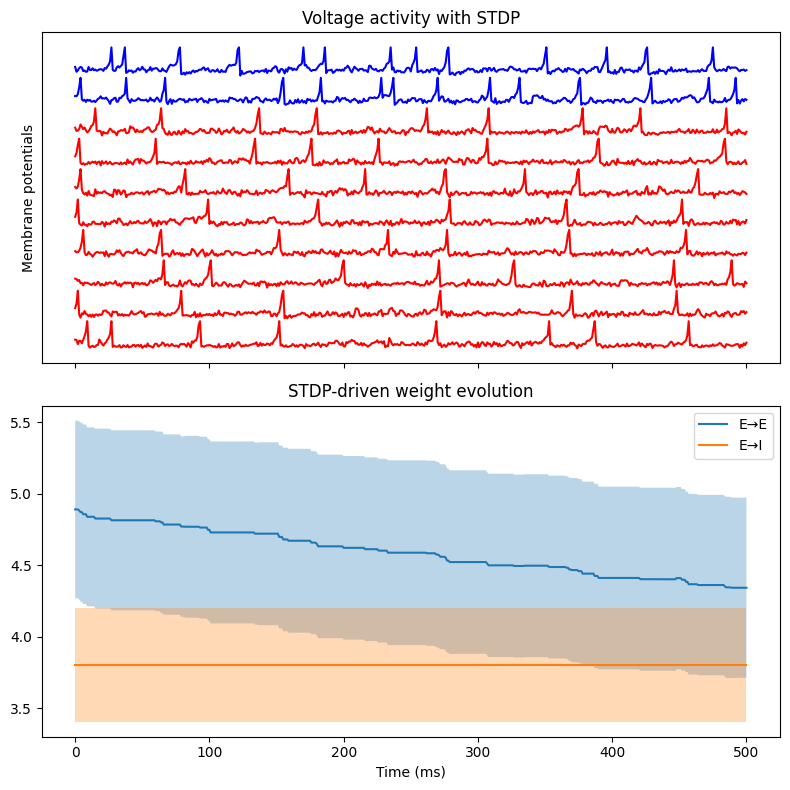

In [ ]:
# we use the above Izhikevich neuronal network model along with STDP
# connectivity options:
# A: exponential distr for E and I; B: uniform [-5,5] distr for E and I; C: exponential distr E<->E
# -------------------------

# simulation and net size params
N = 10
dt, t_end = 1.0, 500.0
T = np.arange(0.0, t_end + dt, dt)

# dale's law
weight_option = 'A'
if weight_option == 'A':
    N_exc = math.floor(0.8*N)
    N_inh = N - N_exc
    W = np.zeros((N, N))
    exc = np.arange(N_exc)
    inh = np.arange(N_exc, N)
    W[exc, :] = np.random.exponential(scale=5.0, size=(N_exc, N))
    W[inh, :] = -np.random.exponential(scale=5.0, size=(N_inh, N))
elif weight_option == 'B':
    W = np.random.uniform(-5.0, 5.0, size=(N, N))
    pos = np.sum(W > 0, axis=1)
    neg = np.sum(W < 0, axis=1)
    exc = np.where(pos >= neg)[0] # majority positive weights
    inh = np.where(neg > pos)[0]  # majority negative weights
    W[exc, :] =  np.abs(W[exc, :])
    W[inh, :] = -np.abs(W[inh, :])
else:  # 'C'
    W = np.random.exponential(5.0, size=(N, N))
    exc = np.arange(N)
    inh = np.array([], dtype=int)
# remove self-connections
np.fill_diagonal(W, 0.0)

# Izhikevich params
a = np.empty(N); b = np.empty(N)
c = np.empty(N); d = np.empty(N)
# regular-spiking (excitatory)
a[exc], b[exc], c[exc], d[exc] = 0.02, 0.2, -65.0, 8.0
# fast-spiking (inhibitory)
a[inh], b[inh], c[inh], d[inh] = 0.1, 0.2, -65.0, 2.0

# noise params
noise_std = 10.0
v = np.random.uniform(-65.0, -45.0, size=N)
u = b * v
V = np.zeros((len(T), N))

# STDP params
A_LTP = 1.0
A_LTD = np.random.uniform(0.8, 1.5)
tau_LTP = 20.0
tau_LTD = np.random.uniform(20, 30)
w_max = 20.0
w_min = 0.0
last_spike = -np.inf * np.ones(N)
def _apply_stdp(t, fired):
    # only applied for E->E
    for n in np.where(fired)[0]:
        if n not in exc:
            continue
        # note: last spike times are at most equal to `t` at this step
        delta_t = t - last_spike[exc]  # Δt >= 0
        mask = delta_t > 0
        # first treating n as presynaptic neuron
        ns = exc[mask]  # indices of non-zero difference
        W[n, ns] -= A_LTD * np.exp(-delta_t[mask]/tau_LTD)
        # then treating n as postsynaptic neuron
        W[ns, n] += A_LTP * np.exp(-delta_t[mask]/tau_LTP)
    # finally applying weight decay and clipping to excitatory weights only
    exc_mat = np.ix_(exc, exc)
    W[exc_mat] = np.clip(W[exc_mat], w_min, w_max)

# preallocate weight stats
mask_EE = np.ix_(exc, exc)
mask_EI = np.ix_(exc, inh)
mask_IE = np.ix_(inh, exc)
mask_II = np.ix_(inh, inh)
EE_mean = np.zeros_like(T); EI_mean = np.zeros_like(T)
IE_mean = np.zeros_like(T); II_mean = np.zeros_like(T)
EE_sem  = np.zeros_like(T); EI_sem  = np.zeros_like(T)
IE_sem  = np.zeros_like(T); II_sem  = np.zeros_like(T)
def _stats(mask):
    vals = np.abs(W[mask]).ravel()
    if vals.size:
        return vals.mean(), vals.std()/np.sqrt(len(vals))
    return np.nan, np.nan

# network simulation
for ti, t in enumerate(T):
    fired = v >= 30.0
    V[ti] = v
    v[fired] = c[fired]
    u[fired] += d[fired]
    last_spike[fired] = t
    V[ti, fired] = 40.0
    I_rec = W.T.dot(fired.astype(float))
    I_noise = np.random.randn(N) * noise_std
    I_total = I_rec + I_noise
    dv1 = 0.04*v**2 + 5*v + 140 - u + I_total
    v += dv1 * (dt / 2)
    dv2 = 0.04*v**2 + 5*v + 140 - u + I_total
    v += dv2 * (dt / 2)
    du = a * (b * v - u)
    u += du * dt
    _apply_stdp(t, fired)
    EE_mean[ti], EE_sem[ti] = _stats(mask_EE)
    EI_mean[ti], EI_sem[ti] = _stats(mask_EI)
    IE_mean[ti], IE_sem[ti] = _stats(mask_IE)
    II_mean[ti], II_sem[ti] = _stats(mask_II)

# plot neuron membrane potentials
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), sharex=True)
colors = ['red' if i in exc else 'blue' for i in range(N)]
for i in range(N):
    ax1.plot(T, V[:,i] + i*150, color=colors[i])
ax1.set_ylabel("Membrane potentials")
ax1.set_title("Voltage activity with STDP")
ax1.set_yticks([])
for mu, sig, label in [
    (EE_mean, EE_sem, 'E→E'),
    (EI_mean, EI_sem, 'E→I'), # also not updated
    # I->.. weights are not updated in this model
    # (IE_mean, IE_sem, 'I→E'),
    # (II_mean, II_sem, 'I→I'),
]:
    ax2.plot(T, mu, label=label)
    ax2.fill_between(T, mu-sig, mu+sig, alpha=0.3)
ax2.set_xlabel("Time (ms)")
ax2.legend(loc='upper right')
ax2.set_title("STDP-driven weight evolution")
plt.tight_layout()
plt.show()